In [1]:
# so now we will be working on a model which makes use of the entire food vision dataset
# transfer learning with tensorflow part 3

!nvidia-smi

Mon Jun 26 08:58:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# yeeees we are using a tesla t4 gpu for our purpose
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-26 09:01:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-26 09:01:57 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [7]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir


In [8]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-06-26 09:03:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  22.5MB/s    in 68s     

2023-06-26 09:04:29 (22.6 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [9]:
import zipfile
zip_ref = zipfile.ZipFile("101_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [10]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [18]:
 import tensorflow as tf
 import numpy as np
 import pandas as pd
 import matplotlib.pyplot as plt
 import matplotlib.image as mpimg



In [14]:
img_size = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                 label_mode= "categorical",
                                                                 batch_size = 32,
                                                                 image_size = img_size)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                label_mode = "categorical",
                                                                batch_size = 32,
                                                                image_size = img_size,
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [15]:
# # trainaing a big dog model with transfer learning on 10% of the og dataset


# here are the steps we are going to take
# 1. setting up a model checkpoint callback
# 2. create a data augmentation layer to build data augmentation into the model
# 3. build a headless functional efficient net model with our own output layer
# 4. compile our model
# # 5. feature extract for 5 full passes validated on only 15% of the data

In [16]:
checkpoint_path = "101_classes/checkpoint"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only= True,
                                                         save_best_only=True,
                                                         monitor = "val_accuracy")

In [19]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


In [21]:
data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
])

In [23]:
# setup the base model and freez all of its layers

base_model = tf.keras.applications.EfficientNetB0(include_top = False)

base_model.trainable = False


inputs = layers.Input(shape = (224,224,3), name = "input_layer")

x = data_augmentation(inputs)
x = base_model(x,training = False)
x = layers.GlobalAveragePooling2D(name = "avg_gob_pool")(x)
outputs = layers.Dense(len(train_data.class_names),activation = "softmax", name = "output_layer")(x)
model = tf.keras.Model(inputs,outputs)


In [24]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 avg_gob_pool (GlobalAverage  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
___________________________________________

In [25]:
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [26]:
history = model.fit(train_data,
                    epochs = 5,
                    steps_per_epoch = len(train_data),
                    validation_data = test_data,
                    validation_steps = int(0.25 * len(test_data)),
                    callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 130s 474ms/step - loss: 3.3811 - accuracy: 0.2702 - val_loss: 2.5570 - val_accuracy: 0.4089
Epoch 2/5
237/237 [==============================] - 85s 358ms/step - loss: 2.1908 - accuracy: 0.5052 - val_loss: 2.0919 - val_accuracy: 0.4846
Epoch 3/5
237/237 [==============================] - 77s 320ms/step - loss: 1.8178 - accuracy: 0.5721 - val_loss: 1.9252 - val_accuracy: 0.5078
Epoch 4/5
237/237 [==============================] - 73s 305ms/step - loss: 1.6110 - accuracy: 0.6048 - val_loss: 1.8263 - val_accuracy: 0.5246
Epoch 5/5
237/237 [==============================] - 60s 249ms/step - loss: 1.4547 - accuracy: 0.6465 - val_loss: 1.7606 - val_accuracy: 0.5360


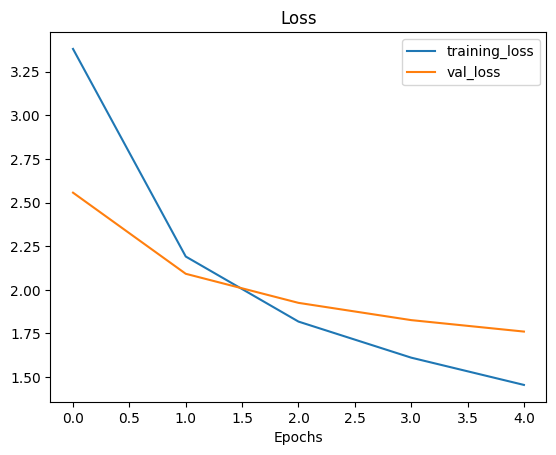

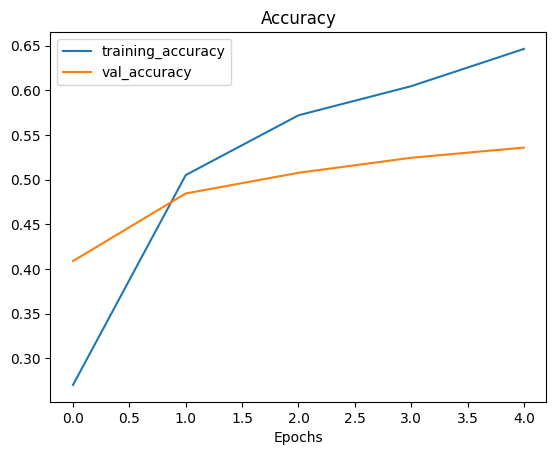

In [28]:
plot_loss_curves(history)

In [34]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False
  print(layer.name, layer.trainable)

input_2 False
rescaling_2 False
normalization_1 False
rescaling_3 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [35]:
for layer in base_model.layers:
  print(layer.name, layer.trainable)

input_2 False
rescaling_2 False
normalization_1 False
rescaling_3 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [36]:
# recompile model with lower learning rate

model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
              metrics = ["accuracy"])

In [37]:
history1 = model.fit(train_data,
                     epochs = 10,
                     validation_data = test_data,
                     validation_steps = int(0.25 * len(test_data)),
                     initial_epoch = history.epoch[-1])

Epoch 5/10
237/237 [==============================] - 73s 259ms/step - loss: 1.4944 - accuracy: 0.6001 - val_loss: 1.8070 - val_accuracy: 0.5195
Epoch 6/10
237/237 [==============================] - 65s 270ms/step - loss: 1.0911 - accuracy: 0.6991 - val_loss: 1.8138 - val_accuracy: 0.5311
Epoch 7/10
237/237 [==============================] - 54s 227ms/step - loss: 0.8218 - accuracy: 0.7725 - val_loss: 1.8448 - val_accuracy: 0.5292
Epoch 8/10
237/237 [==============================] - 53s 218ms/step - loss: 0.6643 - accuracy: 0.8117 - val_loss: 2.0674 - val_accuracy: 0.5082
Epoch 9/10
237/237 [==============================] - 50s 209ms/step - loss: 0.5049 - accuracy: 0.8539 - val_loss: 2.1809 - val_accuracy: 0.4965
Epoch 10/10
237/237 [==============================] - 57s 239ms/step - loss: 0.4310 - accuracy: 0.8713 - val_loss: 2.0640 - val_accuracy: 0.5297


In [38]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-06-26 11:11:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.128, 172.253.118.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  13.9MB/s    in 3.2s    

2023-06-26 11:11:59 (13.9 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [39]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [40]:
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [41]:
results_downloaded = model.evaluate(test_data)

790/790 [==============================] - 75s 92ms/step - loss: 1.8027 - accuracy: 0.6078


In [42]:
results_downloaded

[1.8027206659317017, 0.6077623963356018]

In [43]:
# making predictions with our trained model
pred_probs = model.predict(test_data,verbose = 1)

790/790 [==============================] - 66s 81ms/step


In [44]:
len(pred_probs)

25250

In [45]:
pred_probs.shape

(25250, 101)

In [48]:
# y_labels = []
# for images,labels in test_data.unbatch():
#   y_labels.append(labels.numpy().argmax())


In [50]:
# y_labels_onehot = []
# for images,labels in test_data.unbatch():
#   y_labels_onehot.append(labels.numpy())